In [1]:
# iMPORT PACKAGES
import pandas as pd
import datetime as dt
import numpy as np

from datetime import timedelta

import matplotlib.pyplot as plt

import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from time import time

# for multivariate data preparation
from numpy import array
from numpy import hstack

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [313]:
""" 
# READ FILE
path = '/Users/cathytol/Documents/DMT/DMT/'
inputPath = path + "out_without_nan_mood_target_normalised.csv"
df = pd.read_csv(inputPath)
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset = ['mood_mean','mood_mean_TARGET'] ).reset_index(drop=True)
"""

In [3]:
# READ FILES
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [4]:
# split train set again in test and train for development
test2 = train.groupby("id").tail(6).reset_index(drop =True)
train2 = (train.ix[train.index.difference(train.groupby('id').tail(6).index)])

/Users/cathytol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
print(len(test2))
print(len(train2))
print(len(test2)/len(train2))

162
730
0.2219178082191781


In [6]:
print(len(test))
print(len(train))
print(len(test)/len(train))

324
892
0.3632286995515695


In [7]:
train2.head()

,id,date,activity_mean,circumplex.arousal_mean,circumplex.valence_mean,mood_mean,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,...,lastTimeSeenMood_5,numberOfTimesSeenMood5Days_5,lastTimeSeenMood_6,numberOfTimesSeenMood5Days_6,lastTimeSeenMood_7,numberOfTimesSeenMood5Days_7,lastTimeSeenMood_8,numberOfTimesSeenMood5Days_8,lastTimeSeenMood_9,numberOfTimesSeenMood5Days_9
0,AS14.01,2014-02-26,0.000000,0.4375,0.615385,0.513158,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.030303,0.145455,0.0,0.101266,0.0,0.079208,0.0
1,AS14.01,2014-03-21,0.236766,0.5500,0.446154,0.505263,0.077850,0.303150,0.028033,0.037502,...,0.0,0.0,0.0,0.090909,0.490909,0.0,0.341772,0.0,0.267327,0.0
2,AS14.01,2014-03-22,0.418390,0.6500,0.538462,0.536842,0.018139,0.239538,0.002597,0.015953,...,0.0,0.0,0.0,0.121212,0.509091,0.0,0.354430,0.0,0.277228,0.0
3,AS14.01,2014-03-23,0.252117,0.5500,0.630769,0.600000,0.031898,0.252782,0.002625,0.032854,...,0.0,0.0,0.0,0.151515,0.527273,0.0,0.367089,0.0,0.287129,0.0
4,AS14.01,2014-03-24,0.139465,0.7000,0.384615,0.473684,0.021500,0.447451,0.027185,0.025816,...,0.0,0.0,0.0,0.181818,0.545455,0.0,0.379747,0.0,0.297030,0.0


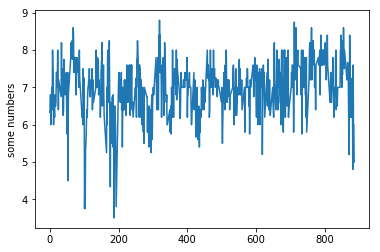

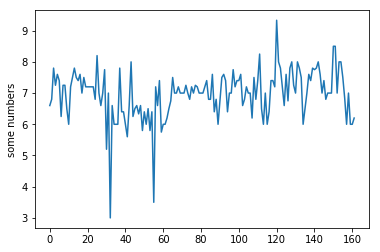

In [70]:
import matplotlib.pyplot as plt
plt.plot(train['mood_mean_TARGET'])
plt.ylabel('some numbers')
plt.show()

plt.plot(test['mood_mean_TARGET'])
plt.ylabel('some numbers')
plt.show()

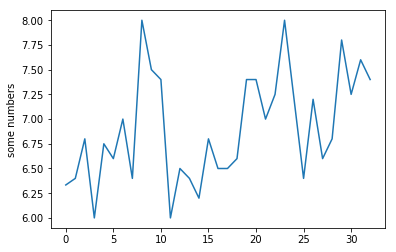

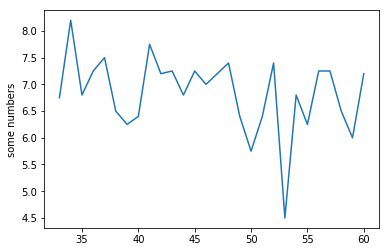

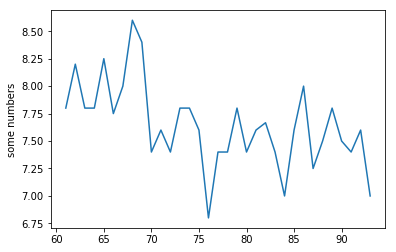

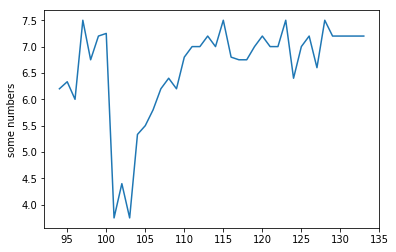

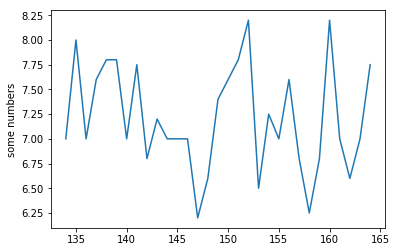

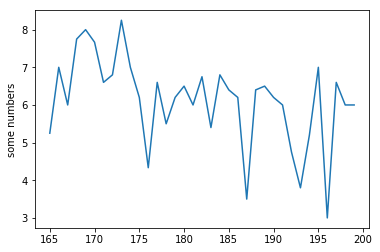

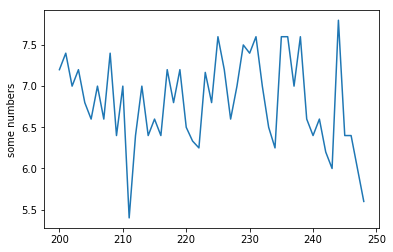

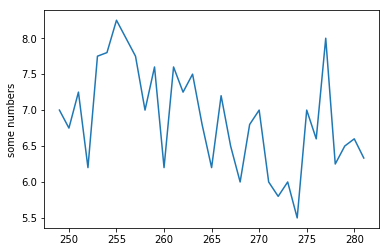

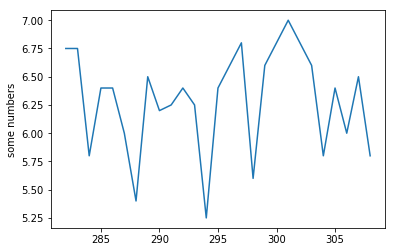

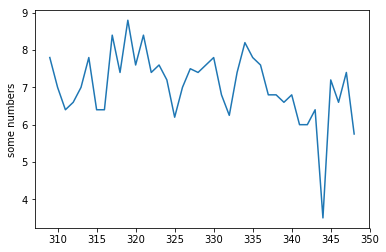

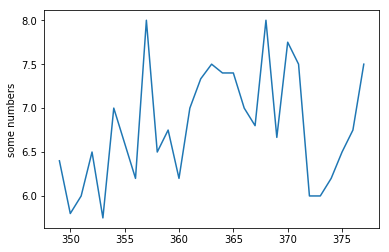

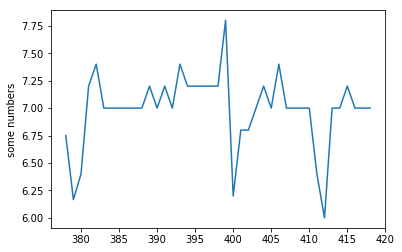

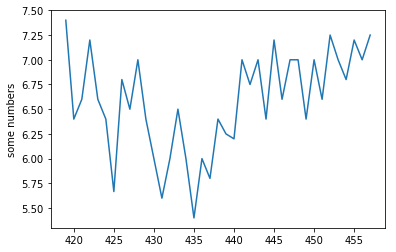

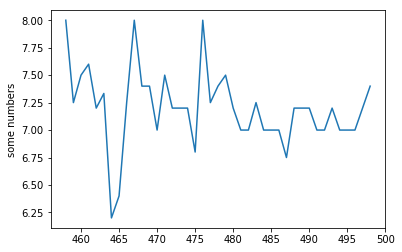

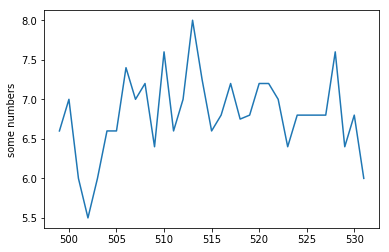

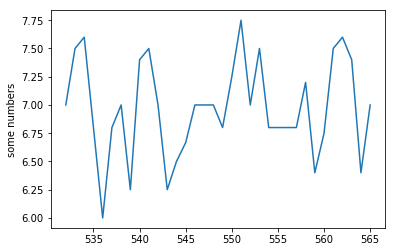

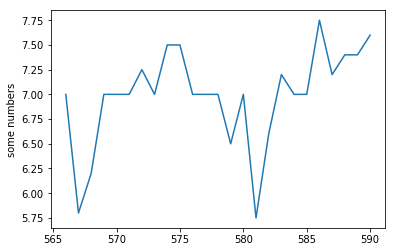

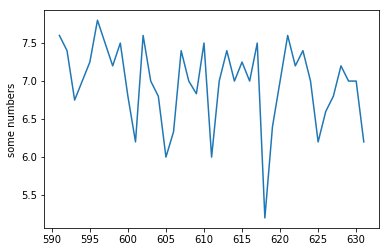

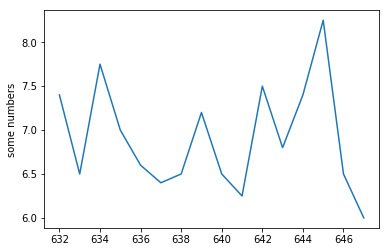

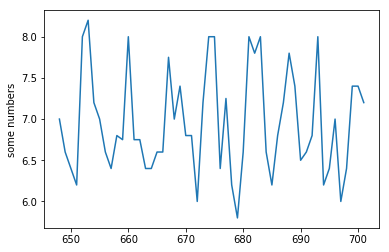

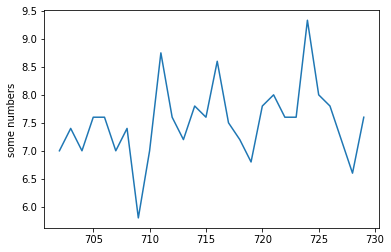

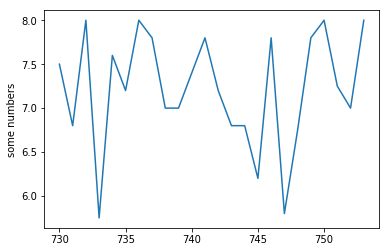

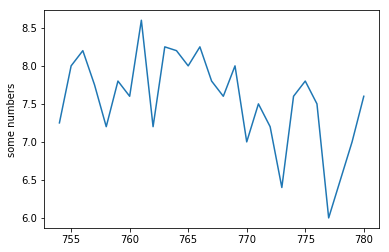

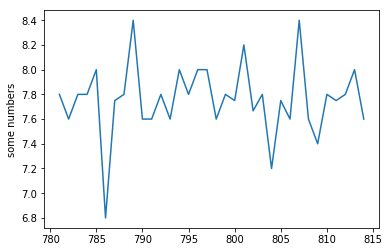

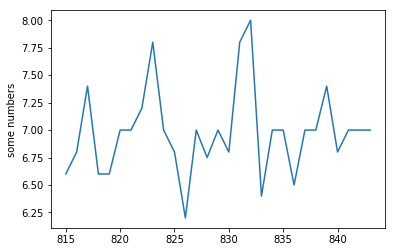

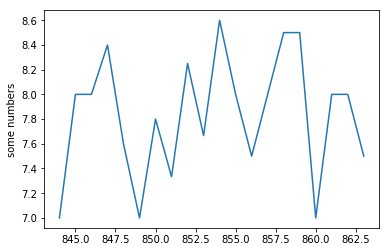

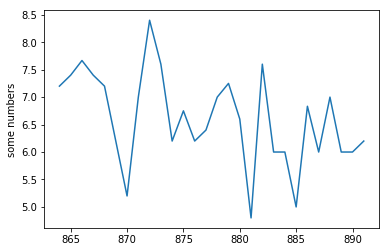

In [29]:
for name, group in train.groupby('id'):
    plt.plot(group['mood_mean_TARGET'])
    plt.ylabel('some numbers')
    plt.show()
    

## uni variate

In [78]:
def create_dataset1(dataset, look_back=1):
    dataX, dataY = [], []
    for name, group in dataset.groupby('id'):
        x = list(group['mood_mean'])
        y = list(group['mood_mean_TARGET'])
        for i in range(len(group)-look_back):
            dataX.append(x[i:(i+look_back)])
            dataY.append(y[i + look_back-1])
    return np.array(dataX), np.array(dataY)


def trainRNN1(train, test, look_back):
    trainX, trainY = create_dataset1(train[['id', 'mood_mean', 'mood_mean_TARGET']], look_back)
    testX, testY = create_dataset1(test[['id', 'mood_mean', 'mood_mean_TARGET']], look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    t = time()

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=0)

    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
    
    return model, trainX, testX, trainY, testY

def doRNN1(model, trainX, testX, trainY, testY):
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # calculate root mean squared error
    #trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    trainScore = mean_squared_error(trainY, trainPredict[:,0])
    print('Train Score: %.3f MSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    testScore = mean_squared_error(testY, testPredict[:,0])
    print('Test Score: %.3f MSE' % (testScore))

    return trainPredict, testPredict

def giveR2(trainY, trainPredict, testY, testPredict):
    meanY = sum(trainY)/len(trainY)
    SStotal = 0
    SSres = 0
    for value, f in zip(trainY, list(trainPredict[:,0])):
        SStotal += math.pow(value-meanY,2)
        SSres += math.pow(value-f,2)

    print("R2 of train: ", 1-SSres/SStotal)


    meanY = sum(testY)/len(testY)
    SStotal = 0
    SSres = 0
    for value, f in zip(testY, list(testPredict[:,0])):
        SStotal += math.pow(value-meanY,2)
        SSres += math.pow(value-f,2)

    print("R2 of test: ", 1-SSres/SStotal)


In [79]:
for look_back in range(5,6):
    print("LOOK_BACK = ", look_back)
    model, trainX, testX, trainY, testY = trainRNN1(train2, test2, look_back)
    trainPredict, testPredict = doRNN1(model, trainX, testX, trainY, testY)
    giveR2(trainY, trainPredict, testY, testPredict)
    

LOOK_BACK =  5
Time to train the model: 0.43 mins
Train Score: 0.414 MSE
Test Score: 0.365 MSE
R2 of train:  0.2376367342868061
R2 of test:  0.34017428231897595


In [100]:
sum(list(abs(testPredict[:,0] - testY)))/len(list(testPredict[:,0] - testY))

0.46412470344933676

In [102]:
np.std(list(abs(testPredict[:,0] - testY)))

0.38672296405227724

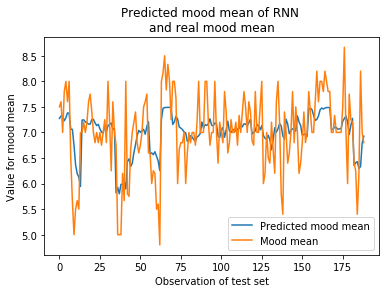

In [88]:
import matplotlib.pyplot as plt
plt.plot(list(testPredict[:,0]))
plt.plot(testY)
plt.legend(["Predicted mood mean", "Mood mean"])
plt.xlabel('Observation of test set')
plt.ylabel('Value for mood mean')
plt.title('Predicted mood mean of RNN \nand real mood mean')
plt.savefig("rnn1")

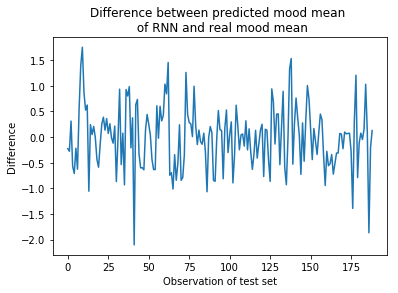

In [90]:
plt.plot(list(testPredict[:,0]) - testY)
plt.xlabel('Observation of test set')
plt.ylabel('Difference')
plt.title('Difference between predicted mood mean \n of RNN and real mood mean')

plt.savefig("rnn2")

In [164]:
""" 
# Create empty df to save solutions
solutionsTrain = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in train.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTrain = solutionsTrain.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': trainPredict[j]}, ignore_index=True)
        j += 1   
        

# Create empty df to save solutions
solutionsTest = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in test.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTest = solutionsTest.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': testPredict[j]}, ignore_index=True)
        j += 1 
        
"""

## multi variate

In [73]:
def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for name, group in dataset.groupby('id'):
        #define input sequences
        in_seq1 = array(list(group['mood_mean']))
        in_seq2 = array(list(group['circumplex.valence_mean']))
        out_seq = array(list(group['mood_mean_TARGET']))
        #out_seq = list(group['mood_mean_TARGET'])
        #out_seq = array(out_seq[1:] + [np.nan])
        
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        out_seq = out_seq.reshape((len(out_seq), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2, out_seq))
        
        for i in range(len(group)-look_back):
            dataX.append(dataset[i:i+look_back, :-1])
            dataY.append(dataset[i+look_back-1, -1])
    return np.array(dataX), np.array(dataY)


def trainRNN2(train, test, look_back):
    trainX, trainY = create_dataset2(train[['id', 'mood_mean', 'circumplex.valence_mean', 'mood_mean_TARGET']], look_back)
    testX, testY = create_dataset2(test[['id', 'mood_mean', 'circumplex.valence_mean', 'mood_mean_TARGET']], look_back)
    
    t = time()

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 2)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(trainX, trainY, epochs=50, verbose=0)

    print('Time to train: {} mins'.format(round((time() - t) / 60, 2)))
    
    return model, trainX, testX, trainY, testY

def doRNN2(model, trainX, testX, trainY, testY):
    YhatsTrain = []
    for x in trainX:
        x = x.reshape((1, look_back, 2))
        y = model.predict(x, verbose = 0)
        YhatsTrain += [y[0][0]]

    YhatsTest = []
    for x in testX:
        x = x.reshape((1, look_back, 2))
        y = model.predict(x, verbose = 0)
        YhatsTest += [y[0][0]]
        
    trainScore = mean_squared_error(trainY, YhatsTrain)
    print('Train Score: %.3f MSE' % (trainScore))
    testScore = mean_squared_error(testY, YhatsTest)
    print('Test Score: %.3f MSE' % (testScore))
    
    return YhatsTrain, YhatsTest 
    
    
def giveR2(trainY, trainPredict, testY, testPredict):
    meanY = sum(trainY)/len(trainY)
    SStotal = 0
    SSres = 0
    for value, f in zip(trainY, list(trainPredict)):
        SStotal += math.pow(value-meanY,2)
        SSres += math.pow(value-f,2)

    print("R2 of train: ", 1-SSres/SStotal)


    meanY = sum(testY)/len(testY)
    SStotal = 0
    SSres = 0
    for value, f in zip(testY, list(testPredict)):
        SStotal += math.pow(value-meanY,2)
        SSres += math.pow(value-f,2)

    print("R2 of test: ", 1-SSres/SStotal)







In [74]:
for look_back in range(1,6):
    print("LOOK_BACK = ", look_back)
    model, trainX, testX, trainY, testY = trainRNN2(train2, test2, look_back)
    trainPredict, testPredict = doRNN2(model, trainX, testX, trainY, testY)
    giveR2(trainY, trainPredict, testY, testPredict)

LOOK_BACK =  1
Time to train: 0.14 mins
Train Score: 0.938 MSE
Test Score: 1.247 MSE
R2 of train:  -0.8661891309610694
R2 of test:  -1.0236959331677196
LOOK_BACK =  2
Time to train: 0.15 mins
Train Score: 0.387 MSE
Test Score: 0.581 MSE
R2 of train:  0.24130925378941448
R2 of test:  0.060336998370708494
LOOK_BACK =  3
Time to train: 0.17 mins
Train Score: 0.397 MSE
Test Score: 0.397 MSE
R2 of train:  0.22343729331078
R2 of test:  0.20010921517867664
LOOK_BACK =  4
Time to train: 0.2 mins
Train Score: 0.456 MSE
Test Score: 0.334 MSE
R2 of train:  0.1080556670878493
R2 of test:  -0.07807200020732341
LOOK_BACK =  5
Time to train: 0.19 mins
Train Score: 0.403 MSE
Test Score: 0.272 MSE
R2 of train:  0.21373158192703934
R2 of test:  0.12614171106964978
